## Consigna 1

1)	Desarrollar al menos dos modelos de clasificación (decision tree, logistic regression) que tengan como target feature categoria_socio.
* La target feature podrá asumir dos valores: 
●	Standard.
●	 Silver + Gold.

Aplicar las buenas prácticas en la construcción de modelos: dividir datos en conjunto de entrenamiento y validación, cross-validation, grid-search.

Obtener feature importance.

El objetivo es entender las diferencias entre las distintas categorías de afiliados. Cuáles son las variables más relevantes para diferenciarlos?

Las conclusiones obtenidas a partir de este modelo resultarán de gran importancia para el desarrollo de un modelo de recomendación.

### Importación de librerías y datasets

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
import seaborn as sns
import ptitprince as pt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV ,  train_test_split
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [19]:
df_procesado=pd.read_csv('../Data/df_procesado.csv')
df_procesado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 37 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   id_consumo_encoded                                                                 2500 non-null   int64  
 1   id_socio_encoded                                                                   2500 non-null   int64  
 2   id_prestador_encoded                                                               2500 non-null   int64  
 3   calificacion_experiencia_encoded                                                   2500 non-null   float64
 4   id_zona_encoded                                                                    2500 non-null   int64  
 5   edad_encoded                                                                       2500 non-null   int64

In [20]:
df_procesado

,id_consumo_encoded,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,id_zona_encoded,edad_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,...,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0,categoria_prestador_gold,categoria_prestador_silver,categoria_prestador_standard,categoria_socio_gold,categoria_socio_silver,categoria_socio_standard
0,1,100000,200000,0.666667,1,81,5.750000,1,0,1,...,1,0,0,1,1,0,0,0,0,1
1,2,100000,200000,0.555556,1,81,5.750000,1,0,1,...,1,0,0,1,1,0,0,0,0,1
2,4,100002,200000,0.666667,2,60,6.333333,1,0,0,...,1,0,0,1,1,0,0,0,0,1
3,12,100010,200000,0.666667,7,43,5.666667,1,0,1,...,0,0,0,1,1,0,0,0,0,1
4,22,100017,200000,0.666667,4,47,5.833333,1,0,0,...,1,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2001,101548,200193,0.222222,1,3,1.083333,0,1,0,...,0,1,0,0,0,0,1,0,0,1
2496,2080,101612,200193,0.111111,8,5,1.750000,0,1,0,...,0,0,1,0,0,0,1,0,0,1
2497,2088,101618,200194,0.111111,9,3,1.000000,1,0,0,...,0,1,0,0,0,0,1,0,0,1
2498,2327,101791,200195,0.111111,1,8,2.416667,0,1,0,...,0,0,1,0,0,0,1,0,0,1


In [21]:
features_eliminar = ['id_consumo_encoded','id_prestador_encoded','id_socio_encoded','id_zona_encoded' , 'categoria_socio_gold','categoria_socio_silver',
                    'edad_encoded','antiguedad_encoded']
df_procesado.drop(features_eliminar, axis = 1,inplace = True)

X = df_procesado.drop(['categoria_socio_standard'], axis = 1)
Y = df_procesado.categoria_socio_standard

X_train , X_test , y_train , y_test = train_test_split(X , Y , test_size = 0.3 , random_state=42)

In [22]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1750 entries, 1552 to 860
Data columns (total 28 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   calificacion_experiencia_encoded                                                   1750 non-null   float64
 1   sexo_encoded_F                                                                     1750 non-null   int64  
 2   sexo_encoded_M                                                                     1750 non-null   int64  
 3   plan_encoded_a                                                                     1750 non-null   int64  
 4   plan_encoded_b                                                                     1750 non-null   int64  
 5   plan_encoded_c                                                                     1750 non-null   int

In [23]:
df_procesado.categoria_prestador_standard.value_counts()

0    2038
1     462
Name: categoria_prestador_standard, dtype: int64

Text(0.5, 1.0, 'Distribución de clases')

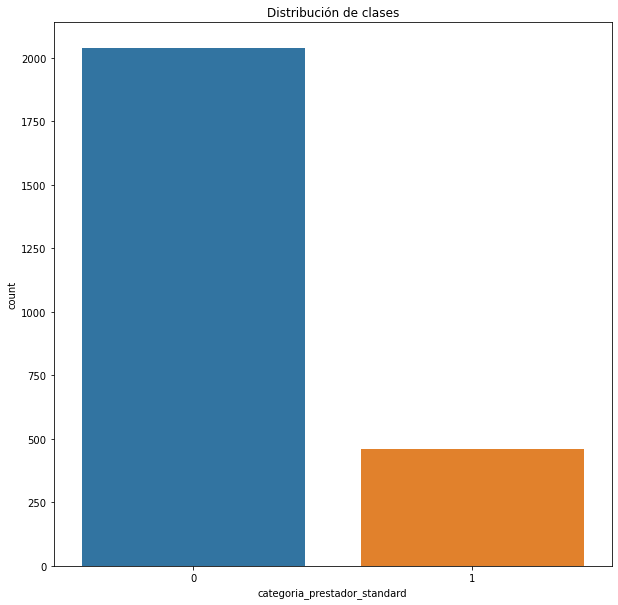

In [24]:
plt.figure(figsize = (10,10))
sns.countplot(data = df_procesado, x='categoria_prestador_standard')
plt.title("Distribución de clases")

Se utilizará GridSearchCV para optimizar los hiperparámetros de tres modelos distintos: Regresión Logística, DecisionTree y RandomForest

In [25]:
lr = LogisticRegression(random_state = 0, class_weight = 'balanced')
dt = DecisionTreeClassifier(random_state = 0 , class_weight = 'balanced')
rf=RandomForestClassifier(random_state=0,class_weight='balanced')

models_parameters= {'logistic_regression': (lr,
                     {'penalty':['l1','l2'],
                     'C':[0.0001,0.001,0.01,0.1,1,10,100],
                     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']})
                     ,'decision_tree': (dt,
                     {'max_depth': [2,3,4,5,10,15,20,25,30,40,50],
                      'criterion': ['gini','entropy']})
                       ,'randonforest': (rf,
                     {'max_depth': [2,3,4,5,10,15,20,25,30,40,50],
                      'n_estimators':[50,100,150,200,300],
                      'criterion': ['gini','entropy']})
                   }

In [26]:
for name, (model, params) in models_parameters.items():

    cv = GridSearchCV(model , cv = 5 , param_grid = params , n_jobs = -1, scoring = 'balanced_accuracy' )

    cv.fit(X_train , y_train)
    
    print(name)
    print(cv.best_score_)
    print(cv.best_params_)

logistic_regression
0.7083984499078839
{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
decision_tree
0.8184676958261864
{'criterion': 'gini', 'max_depth': 10}
randonforest
0.822330220443428
{'criterion': 'gini', 'max_depth': 15, 'n_estimators': 200}


El mejor modelo es RandomForestClassifier Se entrena el modelo con los mejores hiperparámetros

In [31]:
best_model = RandomForestClassifier(random_state = 0 , class_weight = 'balanced' , max_depth = 15 , criterion = 'gini' ,n_estimators=200)

best_model.fit(X_train, y_train)

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

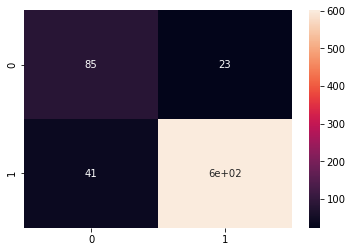

              precision    recall  f1-score   support

           0       0.67      0.79      0.73       108
           1       0.96      0.94      0.95       642

    accuracy                           0.91       750
   macro avg       0.82      0.86      0.84       750
weighted avg       0.92      0.91      0.92       750



In [32]:
cm = confusion_matrix(y_test , y_pred_test)

sns.heatmap(cm , annot = True)
plt.show()

print(classification_report(y_test , y_pred_test))

In [33]:
importance = best_model.feature_importances_
importances = pd.DataFrame({'features': X_train.columns , 'importances': importance})
importances.sort_values(by='importances',ascending=False, inplace = True)

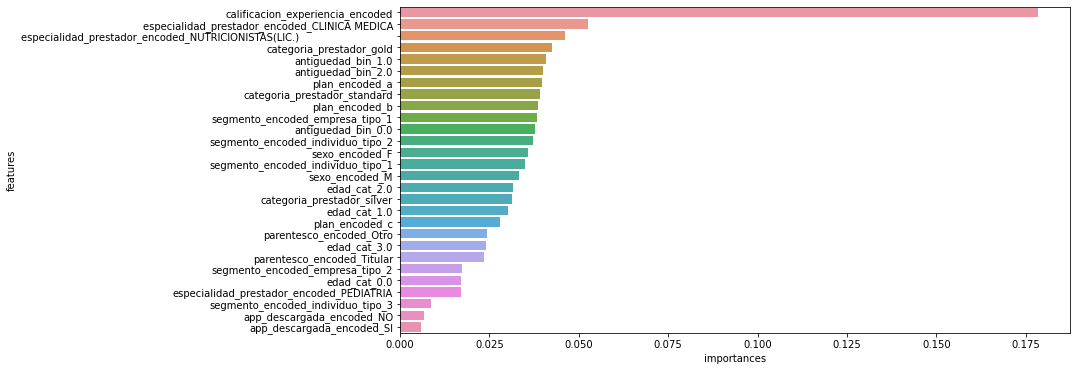

In [34]:
plt.figure(figsize=(12,6))
sns.barplot(data=importances, y='features',x='importances')
plt.show()

In [35]:
df_procesado.columns

Index(['calificacion_experiencia_encoded', 'sexo_encoded_F', 'sexo_encoded_M',
       'plan_encoded_a', 'plan_encoded_b', 'plan_encoded_c',
       'segmento_encoded_empresa_tipo_1', 'segmento_encoded_empresa_tipo_2',
       'segmento_encoded_individuo_tipo_1',
       'segmento_encoded_individuo_tipo_2',
       'segmento_encoded_individuo_tipo_3', 'parentesco_encoded_Otro',
       'parentesco_encoded_Titular', 'app_descargada_encoded_NO',
       'app_descargada_encoded_SI',
       'especialidad_prestador_encoded_CLINICA MEDICA',
       'especialidad_prestador_encoded_NUTRICIONISTAS(LIC.)                              ',
       'especialidad_prestador_encoded_PEDIATRIA', 'edad_cat_0.0',
       'edad_cat_1.0', 'edad_cat_2.0', 'edad_cat_3.0', 'antiguedad_bin_0.0',
       'antiguedad_bin_1.0', 'antiguedad_bin_2.0', 'categoria_prestador_gold',
       'categoria_prestador_silver', 'categoria_prestador_standard',
       'categoria_socio_standard'],
      dtype='object')

### PyCaret

Se hará uso de la librería PyCaret para hacer un análisis similar y encontrar así equivalencias.

In [37]:
from pycaret.classification import *
clf = setup(df_procesado, target='categoria_socio_standard', session_id=42, fix_imbalance = True)

,Description,Value
0,session_id,42
1,Target,categoria_socio_standard
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(2500, 29)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,27
8,Ordinal Features,False
9,High Cardinality Features,False


In [38]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8919,0.8575,0.9232,0.9483,0.9354,0.6035,0.6072,0.0530
rf,Random Forest Classifier,0.8856,0.8899,0.9245,0.9401,0.9320,0.5691,0.5722,0.0570
xgboost,Extreme Gradient Boosting,0.8719,0.9016,0.9225,0.9267,0.9243,0.5044,0.5077,0.3070
lightgbm,Light Gradient Boosting Machine,0.8645,0.8948,0.9299,0.9124,0.9208,0.4460,0.4506,0.1150
dt,Decision Tree Classifier,0.8399,0.7839,0.8814,0.9266,0.9032,0.4403,0.4463,0.0070
gbc,Gradient Boosting Classifier,0.8216,0.8283,0.8726,0.9135,0.8923,0.3698,0.3741,0.0410
knn,K Neighbors Classifier,0.8153,0.8752,0.8214,0.9546,0.8828,0.4580,0.4885,0.1700
ada,Ada Boost Classifier,0.7535,0.7629,0.7830,0.9144,0.8432,0.2805,0.3003,0.0240
lr,Logistic Regression,0.6827,0.7694,0.6692,0.9397,0.7813,0.2575,0.3137,0.3550
lda,Linear Discriminant Analysis,0.6758,0.7679,0.6577,0.9433,0.7746,0.2568,0.3176,0.0070


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

In [39]:
model = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8857,0.8405,0.9195,0.9448,0.9320,0.5752,0.5773
1,0.8686,0.8725,0.8926,0.9500,0.9204,0.5455,0.5543
2,0.8914,0.8490,0.9396,0.9333,0.9365,0.5639,0.5641
3,0.8857,0.8531,0.9128,0.9510,0.9315,0.5876,0.5921
4,0.9143,0.9049,0.9527,0.9463,0.9495,0.6665,0.6667
5,0.8971,0.7681,0.9459,0.9333,0.9396,0.5935,0.5942
6,0.8743,0.8675,0.8986,0.9500,0.9236,0.5703,0.5774
7,0.9143,0.9192,0.9257,0.9716,0.9481,0.7030,0.7099
8,0.8914,0.8630,0.9122,0.9574,0.9343,0.6238,0.6299
9,0.8966,0.8377,0.9324,0.9452,0.9388,0.6055,0.6061


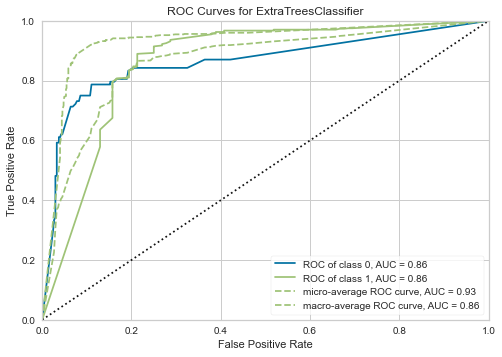

In [40]:
plot_model(model)

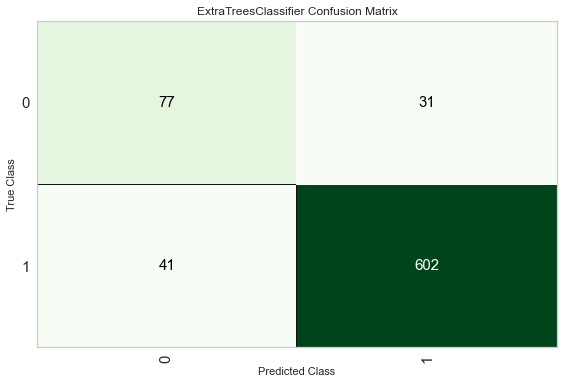

In [41]:
plot_model(model, 'confusion_matrix')

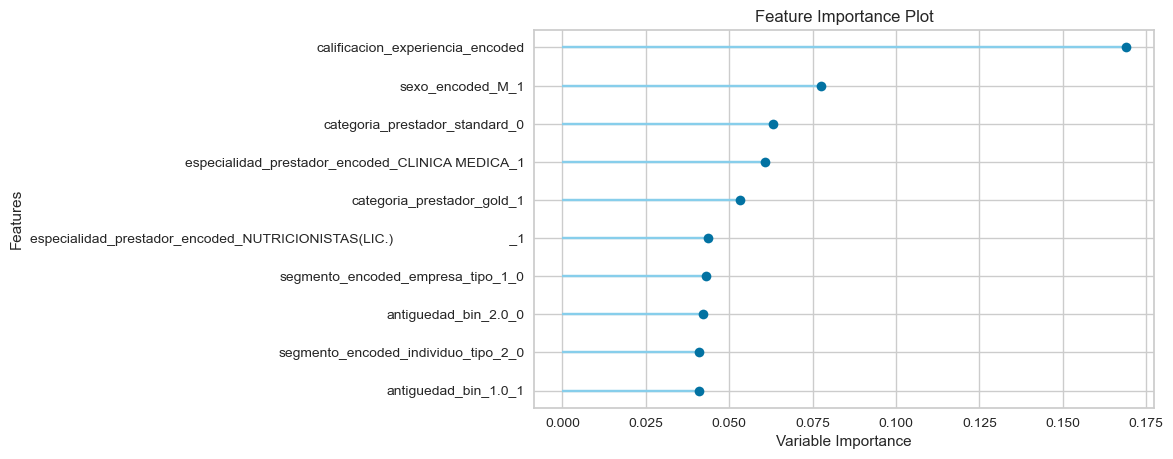

In [42]:
plot_model(model, plot = 'feature')

In [43]:
finalize_model(model)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

# CONSIGNA N° 2

 Desarrollar al menos dos modelos de clasificación (decision tree, logistic regression)que tengan como target feature categoria_prestador.La target feature podrá asumir dos valores:
*  Standard.
* Silver + Gold.
* Aplicar las buenas prácticas en la construcción de modelos: dividir datos en conjunto
de entrenamiento y validación, cross-validation, grid-search.
Obtener feature importance.
Link de interés:
https://machinelearningmastery.com/calculate-feature-importance-with-python/
El objetivo es entender las diferencias entre las distintas categorías de prestadores.
Cuáles son las variables más relevantes para diferenciarlos?
Las conclusiones obtenidas a partir de este modelo resultarán de gran importancia
para el desarrollo de un modelo de recomendación

In [44]:
df_procesado_1=pd.read_csv('../Data/df_procesado.csv')
df_procesado_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 37 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   id_consumo_encoded                                                                 2500 non-null   int64  
 1   id_socio_encoded                                                                   2500 non-null   int64  
 2   id_prestador_encoded                                                               2500 non-null   int64  
 3   calificacion_experiencia_encoded                                                   2500 non-null   float64
 4   id_zona_encoded                                                                    2500 non-null   int64  
 5   edad_encoded                                                                       2500 non-null   int64

In [45]:
features_eliminar = ['id_consumo_encoded','id_prestador_encoded','id_socio_encoded','id_zona_encoded' , 'categoria_prestador_gold','categoria_prestador_silver',
                    'edad_encoded','antiguedad_encoded']
df_procesado_1.drop(features_eliminar, axis = 1,inplace = True)

X_1 = df_procesado_1.drop(['categoria_prestador_standard'], axis = 1)
Y_1 = df_procesado_1.categoria_prestador_standard

X_train_1 , X_test_1 , y_train_1 , y_test_1 = train_test_split(X_1 , Y_1 , test_size = 0.3 , random_state=42)

In [46]:
X_train_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1750 entries, 1552 to 860
Data columns (total 28 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   calificacion_experiencia_encoded                                                   1750 non-null   float64
 1   sexo_encoded_F                                                                     1750 non-null   int64  
 2   sexo_encoded_M                                                                     1750 non-null   int64  
 3   plan_encoded_a                                                                     1750 non-null   int64  
 4   plan_encoded_b                                                                     1750 non-null   int64  
 5   plan_encoded_c                                                                     1750 non-null   int

In [47]:
lr_1 = LogisticRegression(random_state = 0, class_weight = 'balanced')
dt_1 = DecisionTreeClassifier(random_state = 0 , class_weight = 'balanced')

models_parameters_1= {'logistic_regression': (lr_1,
                     {'penalty':['l1','l2'],
                     'C':[0.0001,0.001,0.01,0.1,1,10],
                     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']})
                     ,'decision_tree': (dt_1,
                     {'max_depth': [2,3,4,5,10,15,20,25,30,40,50],
                      'criterion': ['gini','entropy']})}

In [48]:
for name, (model, params) in models_parameters_1.items():

    cv = GridSearchCV(model , cv = 5 , param_grid = params , n_jobs = -1, scoring = 'balanced_accuracy' )

    cv.fit(X_train_1 , y_train_1)
    
    print(name)
    print(cv.best_score_)
    print(cv.best_params_)

logistic_regression
0.8685339222181326
{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
decision_tree
0.8735267528524107
{'criterion': 'gini', 'max_depth': 10}


In [49]:
cv.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [50]:
best_model_1 = DecisionTreeClassifier(random_state = 0 , class_weight = 'balanced' , max_depth = 10 , criterion = 'gini' )

best_model_1.fit(X_train_1, y_train_1)

y_pred_train_1 = best_model_1.predict(X_train_1)
y_pred_test_1 = best_model_1.predict(X_test_1)

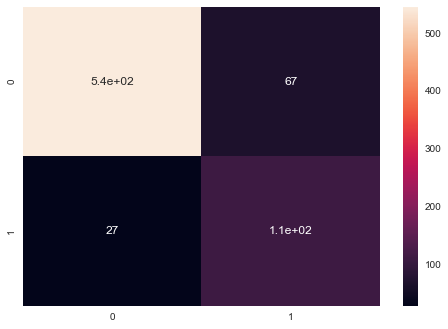

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       612
           1       0.62      0.80      0.70       138

    accuracy                           0.87       750
   macro avg       0.79      0.85      0.81       750
weighted avg       0.89      0.87      0.88       750



In [51]:
cm_1 = confusion_matrix(y_test_1 , y_pred_test_1)

sns.heatmap(cm_1 , annot = True)
plt.show()

print(classification_report(y_test_1 , y_pred_test_1))

In [52]:
importance_1 = best_model_1.feature_importances_
importances_1 = pd.DataFrame({'features': X_train_1.columns , 'importances_1': importance_1})
importances_1.sort_values(by='importances_1',ascending=False, inplace = True)

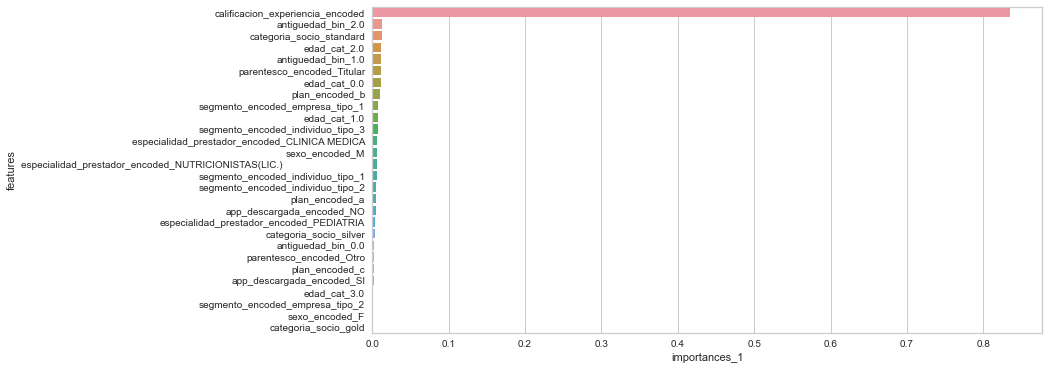

In [53]:
plt.figure(figsize=(12,6))
sns.barplot(data=importances_1, y='features',x='importances_1')
plt.show()